# Analysis of optogenetic stimuli on top of drifting grating stimulus

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import json
from helper_functions import load_sim_results, get_activity, plot_PSTH
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/4068aac5-4e36-4fb3-8ee8-5d612f13c2dd/analyses/simulations.pkl'
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/1978b10b-1508-4584-a71a-2fb8a4809d7a/analyses/simulations.pkl'
sims = pd.read_pickle(sims_file)

In [3]:
# Load results into dataframes
blank_rates_table, stim_rates_table, opto_rates_table, blue_configs, stim_configs, opto_configs = load_sim_results(sims)

In [31]:
# Plot firing rates vs. depolarization
stim_ids = np.unique([int(str.replace(k[str.find(k, '_STIM'):], '_STIM', '')) for k in opto_rates_table.keys() if str.find(k, '_STIM') >= 0])

plt.figure(figsize=(8, 3))
depol = opto_rates_table.index.get_level_values('opto_depol_pct')
plt.plot(depol, blank_rates_table['FullTarget'], '.--', label=f'blank')
for s in stim_ids:
    plt.plot(depol, opto_rates_table[f'FullTarget_STIM{s}'], 'x-', label=f'opto, STIM{s}')
plt.xlabel('Rel. depolarization (%)')
plt.ylabel('Firing rates (Hz)')
plt.legend()
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
# plt.savefig('firing_rates.png', dpi=300)
plt.show()

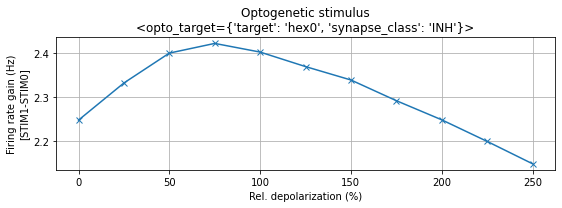

In [53]:
# Plot firing rate gain vs. depolarization
plt.figure(figsize=(8, 3))
plt.plot(depol, opto_rates_table['FullTarget_STIM1'] - opto_rates_table['FullTarget_STIM0'], 'x-')
plt.xlabel('Rel. depolarization (%)')
plt.ylabel('Firing rate gain (Hz)\n[STIM1-STIM0]')
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
# plt.savefig('firing_rate_gain.png', dpi=300)
plt.show()

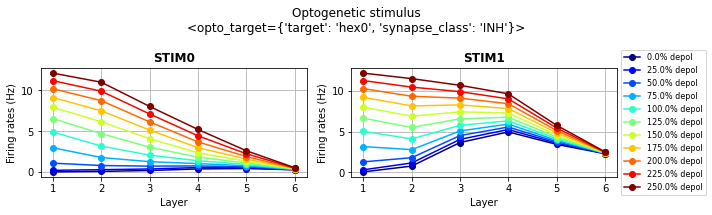

In [40]:
# Plot firing rates vs. injection target layers
num_layers = 6
layer_targets = [f'FullTargetL{lidx + 1}' for lidx in range(num_layers)]
sim_colors = plt.cm.jet(np.linspace(0, 1, sims.shape[0]))
plt.figure(figsize=(10, 3))
for s in stim_ids:
    plt.subplot(1, len(stim_ids), s + 1)
    for sidx in range(sims.shape[0]):
        plt.plot(np.arange(1, num_layers + 1), opto_rates_table.iloc[sidx][[lay + f'_STIM{s}' for lay in layer_targets]], 'o-', color=sim_colors[sidx, :], label=f'{depol[sidx]}% depol')
    plt.xlabel('Layer')
    plt.ylabel('Firing rates (Hz)')
    plt.title(f'STIM{s}', fontweight='bold')
    plt.grid()
plt.legend(loc='center left', fontsize=8, bbox_to_anchor=[1.0, 0.5])
plt.suptitle(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
# plt.savefig('layer_firing_rates.png', dpi=300)
plt.show()

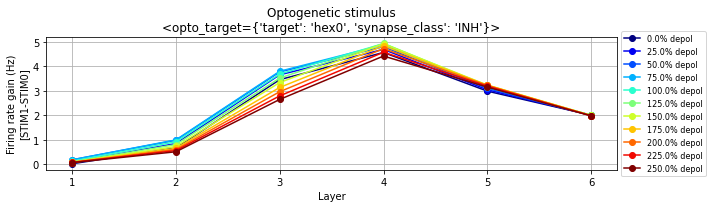

In [52]:
# Plot firing rate gain vs. injection target layers
plt.figure(figsize=(10, 3))
for sidx in range(sims.shape[0]):
    plt.plot(np.arange(1, num_layers + 1), opto_rates_table.iloc[sidx][[lay + '_STIM1' for lay in layer_targets]].to_numpy() - opto_rates_table.iloc[sidx][[lay + '_STIM0' for lay in layer_targets]].to_numpy(), 'o-', color=sim_colors[sidx, :], label=f'{depol[sidx]}% depol')
plt.xlabel('Layer')
plt.ylabel('Firing rate gain (Hz)\n[STIM1-STIM0]')
plt.grid()
plt.legend(loc='center left', fontsize=8, bbox_to_anchor=[1.0, 0.5])
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
# plt.savefig('layer_firing_rates.png', dpi=300)
plt.show()

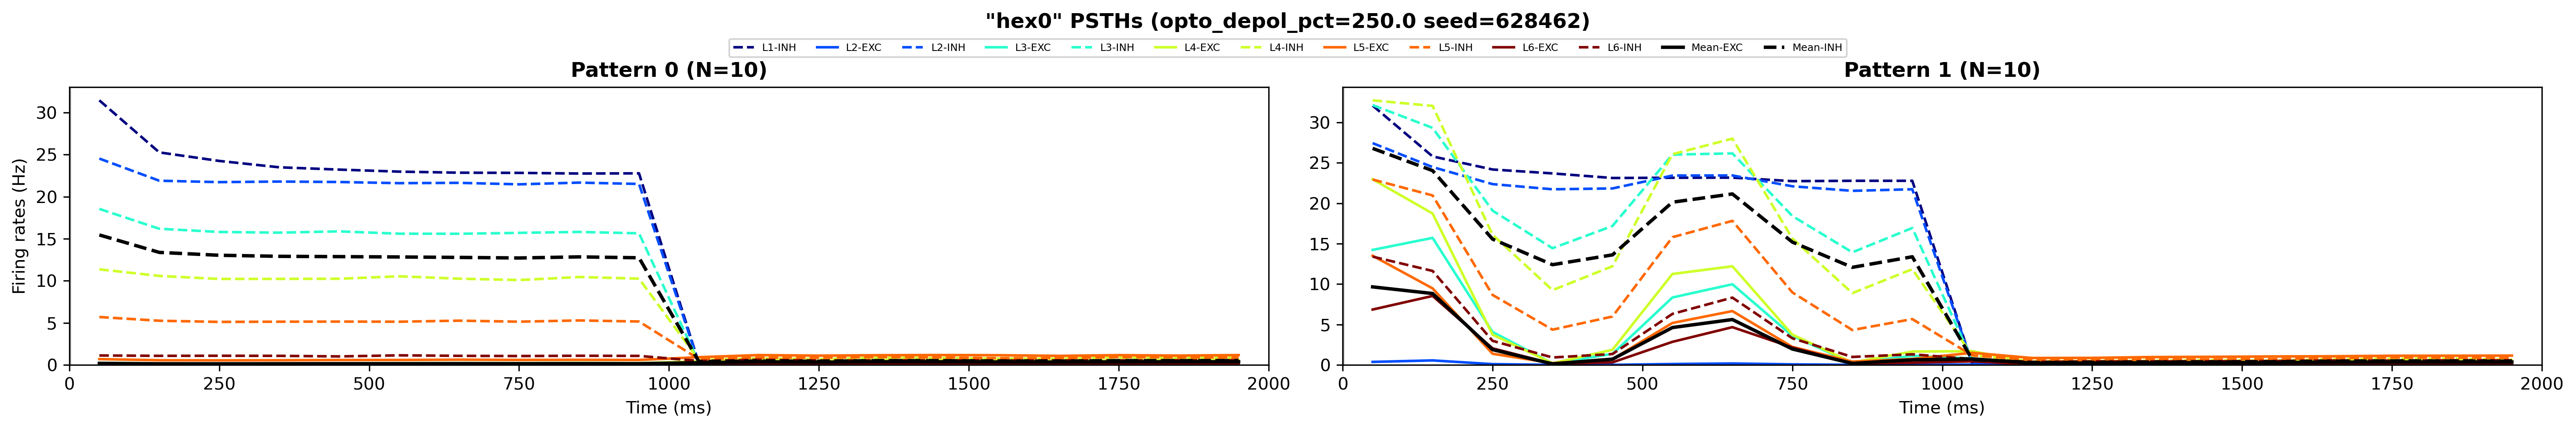

In [84]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=None) # f'psth_{idx}.png'

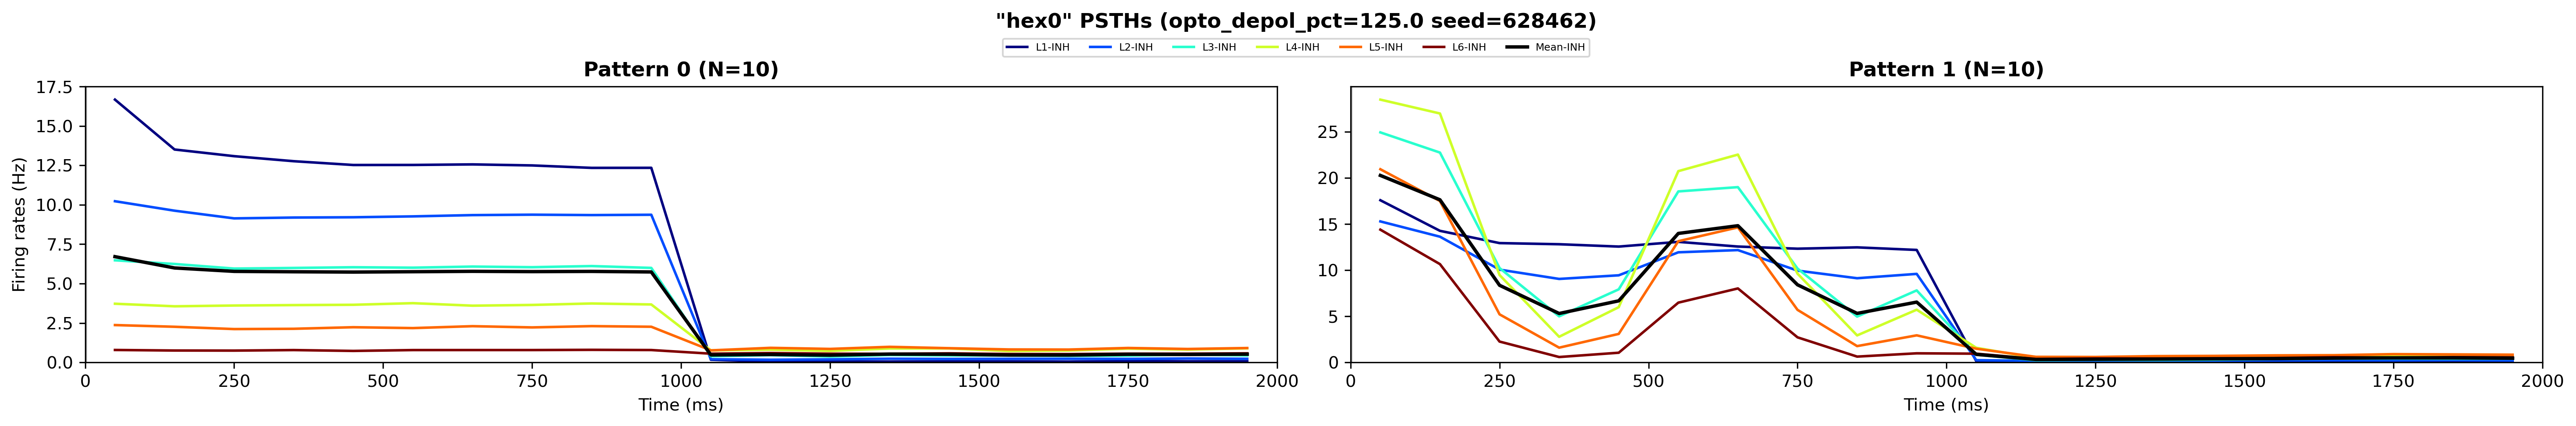

In [98]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', syn_classes=['INH'], label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=None) # f'psth_{idx}.png'

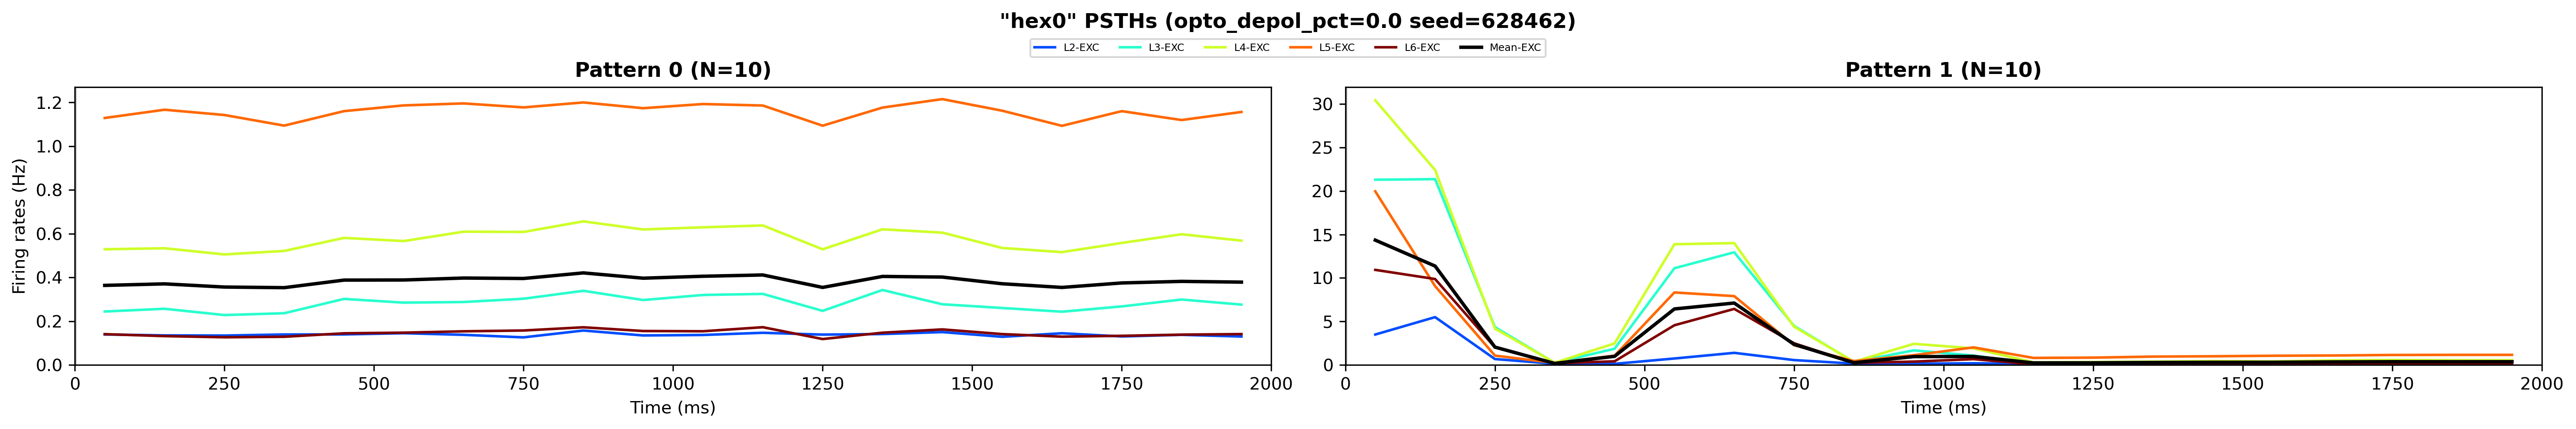

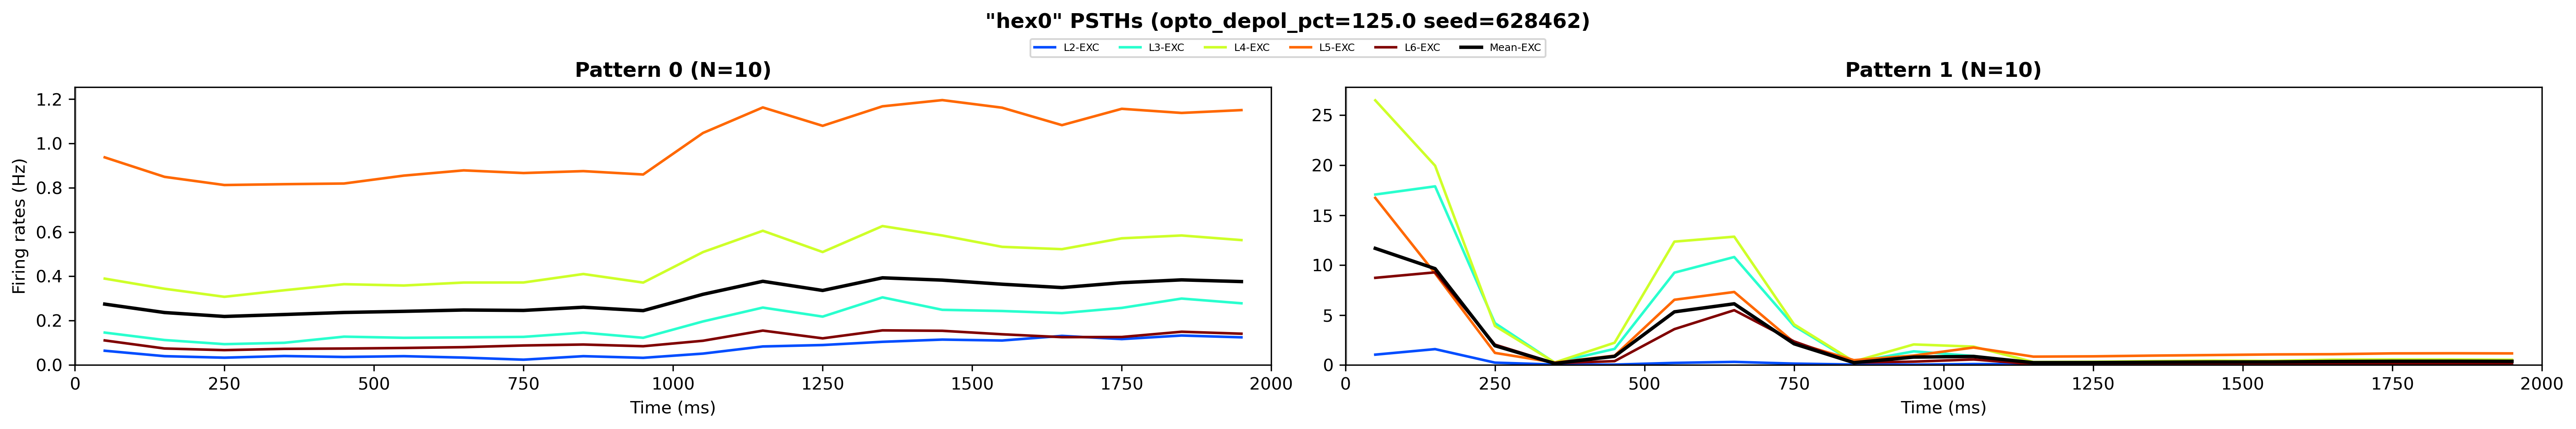

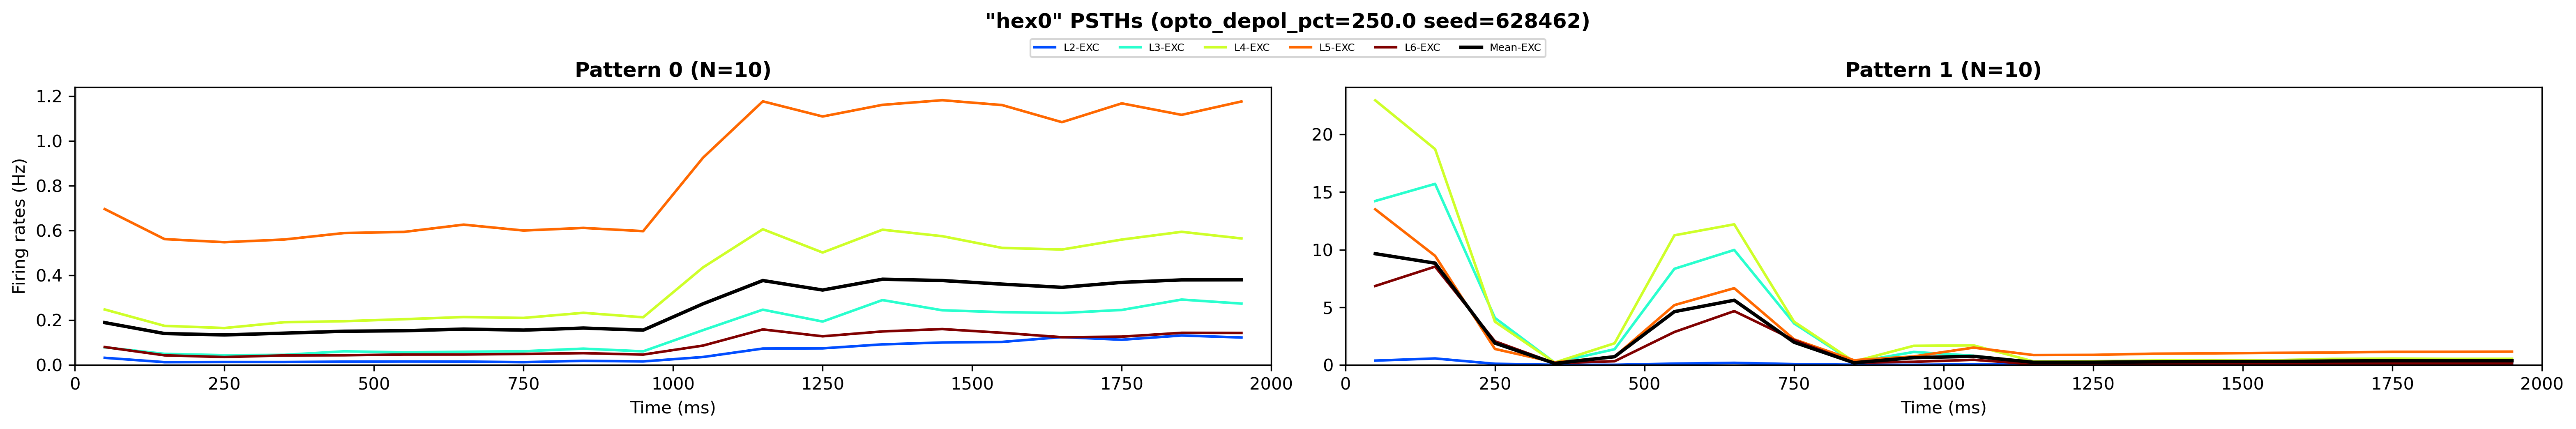

In [99]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', syn_classes=['EXC'], label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=None) # f'psth_{idx}.png'

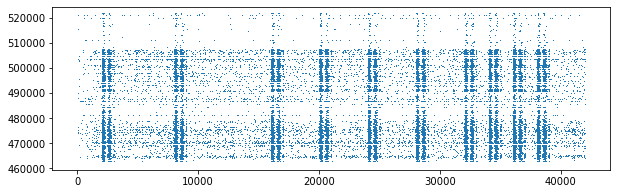

In [267]:
# Spike train visualization (example)
sim = Simulation(sims.iloc[0])
c = sim.circuit
gids = c.cells.ids('hex0')
gids = np.intersect1d(gids, c.cells.ids({'layer': 3, 'synapse_class': 'INH'}))
spikes = sim.spikes.get(gids)
plt.figure(figsize=(10, 3))
plt.plot(spikes.index, spikes.values, ',')
plt.show()

In [ ]:
# Single-cell PSTHs
stim_spikes, stim_rates, stim_cfg, opto_cfg = get_single_cell_psths(sims.iloc[0], {'target': 'hex0', 'synapse_class': 'INH', 'layer': 4})

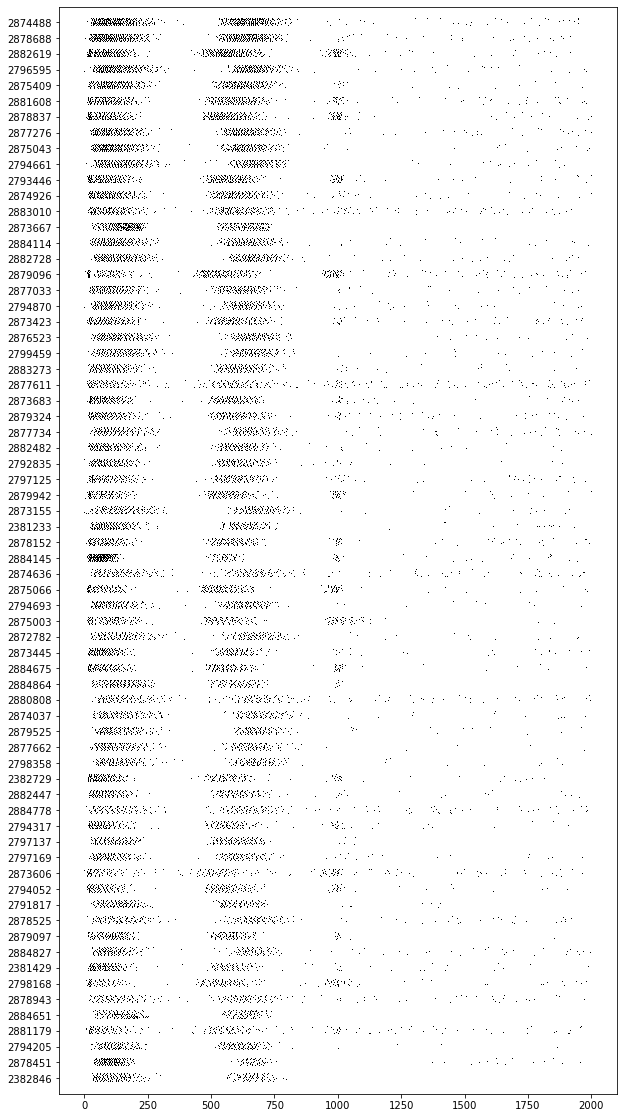

In [277]:
sel_idx = 3
rate_sel = (10.0, np.inf)
y_scale = 0.05
plt.figure(figsize=(10, 20))
gids = np.array(list(stim_spikes[sel_idx].keys()))
rates = np.array(stim_rates[sel_idx])
sort_idx = np.argsort(rates) # Sort by increasing firing rates
gids = gids[sort_idx]
rates = rates[sort_idx]
gids = gids[np.logical_and(rates > rate_sel[0], rates < rate_sel[-1])] # Filter gids based on firing rates
for gidx, gid in enumerate(gids):
    trials = stim_spikes[sel_idx][gid]
    for trial, st in enumerate(trials):
        plt.plot(st, np.full(len(st), (trial - 0.5 * (len(trials) - 1)) * y_scale + gidx), ',k')
plt.yticks(np.arange(len(gids)), gids)
plt.ylim((-1, len(gids)))
plt.show()

In [ ]:
# TODO => Grating + opto stimulus:
# * Single cell activity
#   - Average rates over opto/blank intervals
#   - Instantaneous rates over opto/blank intervals
#   - Peak rates at first/second grating cycle (in case of grating stimulus)